## Find place field order
Since the analysis isn't written in python yet, we can use a magic command to invoke all the analysis code in matlab and run it inline!

First, we invoke the matlab extension:

#### Running MATLAB in python

In [1]:
%load_ext pymatbridge

Starting MATLAB on ZMQ socket ipc:///tmp/pymatbridge-649da1d1-e7f6-4f6b-87cd-0e9321f5e09d
Send 'exit' command to kill the server
.......MATLAB started and connected!


Next, we run some code from the analysis in `Plot_Ordered_Raster` found [here](https://github.com/youkitan/vandermeerlab/blob/master/code-matlab/example_workflows/Plot_Ordered_Raster.ipynb) to get our place cell ordering:

In [2]:
%%matlab -o cell_order

warning('off','all') %only since its annoying otherwise

mvdmlab_path = '/Users/youkitanaka/Documents/Github/vandermeerlab/code-matlab/shared'; 
cd(mvdmlab_path);
p = genpath(pwd);
addpath(p);

proj_path = '/Users/youkitanaka/Documents/Github/vandermeerlab/code-matlab/tasks/Alyssa_Tmaze'; 
cd(proj_path);
p = genpath(pwd);
addpath(p);

cd('/Users/youkitanaka/Documents/data/R050/R050-2014-04-02')

LoadExpKeys;
LoadMetadata;

data.S = LoadSpikes([]);
data.pos = LoadPos([]) ;
data.csc = LoadCSC([]);
data.trials = metadata.taskvars.trial_iv_L; data.trials.type = 'iv';
data.coord = metadata.coord.coordL;
data.stdcoord = StandardizeCoord([],data.coord,334,'pointDist',3);
data.linpos = LinearizePos([],data.pos,data.stdcoord);  

data.tc = TuningCurves([],data.S,data.linpos);
data.fields = DetectPlaceCells1D([],data.tc.tc);

cell_order = data.fields.template_idx;

clearvars -except cell_order

LoadSpikes: Loading 92 files...
LoadPos.m: 100.00% of samples tracked.
LoadCSC: Loading 5 file(s)...
LoadCSC: /Users/youkitanaka/Documents/data/R050/R050-2014-04-02/R050-2014-04-02-CSC06a.ncs 0/17942 bad blocks found (0.00%).
LoadCSC: /Users/youkitanaka/Documents/data/R050/R050-2014-04-02/R050-2014-04-02-CSC07a.ncs 0/17942 bad blocks found (0.00%).
LoadCSC: /Users/youkitanaka/Documents/data/R050/R050-2014-04-02/R050-2014-04-02-CSC08a.ncs 0/17942 bad blocks found (0.00%).
LoadCSC: /Users/youkitanaka/Documents/data/R050/R050-2014-04-02/R050-2014-04-02-HS1R2.ncs 0/17942 bad blocks found (0.00%).
LoadCSC: /Users/youkitanaka/Documents/data/R050/R050-2014-04-02/R050-2014-04-02-HS3R2.ncs 0/17942 bad blocks found (0.00%).
StandardizeCoord: standardizing coord...
StandardizeCoord: input pointDist factors incorrectly. Approximating value...
LinearizePos: linearizing data...


The cool thing with jupyter is that you can invoke the matlab code and tell it to send the data to python!

#### Place cell order

In [3]:
cell_order

array([[ 85.,   5.,  62.,  66.,   6.,  54.,  36.,  53.,  37.,  82.,  65.,
         76.,   4.,  31.,  44.,  52.,  57.,  39.,  84.,  30.,  16.,  27.,
         81.,  59.,   7.,  41.]])

Now that we have a list of the place cell order, let's load the data in python and make our interactive plot!

### Making an interactive raster plot

#### Initialization and data loading

In [4]:
import matplotlib.pyplot as plt
import hypertools as hyp
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import animation, rc
from sklearn.decomposition import PCA
from IPython.display import HTML
import vdmtools as vdm
from vdmtools import printm

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [5]:
cd ratdata/R050-2014-04-02

/Users/youkitanaka/Documents/Github/hypertools-fork/sandbox_rats/ratdata/R050-2014-04-02


In [6]:
data = vdm.loadmat('spikes.mat')
S = data['spikes']
data = vdm.loadmat('lfpTH.mat')
runLFP = data['lfpTH']
data = vdm.loadmat('metadata.mat')
metadata = data['metadata']
data = vdm.loadmat('position.mat')
pos = data['position']

In [7]:
l = pd.Series(runLFP['data'],runLFP['tvec'])
x = pd.Series(pos['data'][0],pos['tvec'])
y = pd.Series(pos['data'][1],pos['tvec'])
lfpdata = pd.DataFrame({'lfp':l,'x_pos':x,'y_pos':y})

In [8]:
idx = cell_order[0].astype(int)
S_ordered = S['t'][idx]
s = {}
for cell in range(len(S_ordered)):
    cellname = idx[cell]
    s[cellname] = pd.Series(np.ones(len(S_ordered[cell])).astype(int),S_ordered[cell])
spikes = pd.DataFrame(s)

In [9]:
lfpdata.head()
spikes.head()

,lfp,x_pos,y_pos
4371.442104,0.000286,NaN,NaN
4371.442604,0.000318,NaN,NaN
4371.443104,0.000348,NaN,NaN
4371.443600,NaN,187.0,331.0
4371.443604,0.000367,NaN,NaN


,4,5,6,7,16,27,30,31,36,37,...,57,59,62,65,66,76,81,82,84,85
4372.0352,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4372.3079,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4372.6089,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4372.7451,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4372.8159,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
tstart = 5000
tend = 6000
S_restr = vdm.restrict(S_ordered,tstart,tend)
lfp_idx = vdm.ridx(runLFP['tvec'],tstart,tend)
lfp_tvec = runLFP['tvec'][lfp_idx]
lfp_data = runLFP['data'][lfp_idx]

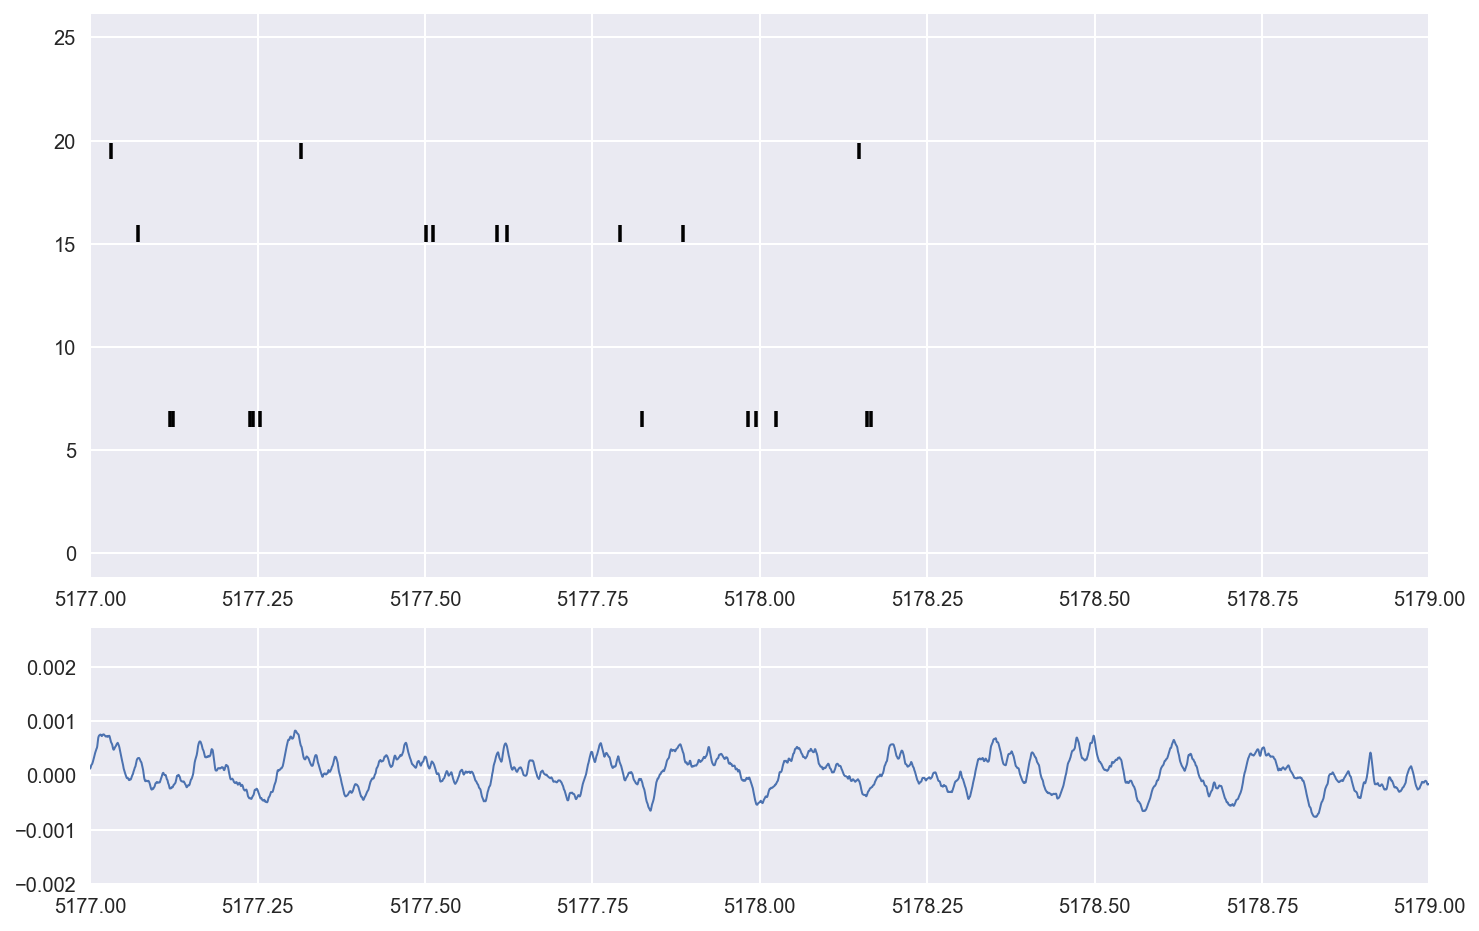

In [12]:
from ipywidgets import widgets
from IPython import display
from matplotlib import gridspec

fig = plt.figure(figsize=(12, 8)) 
gs = gridspec.GridSpec(3, 1) 

ax0 = fig.add_subplot(gs[:-1,0])
for i in range(np.size(S_restr)-1):
    ax0.vlines(S_restr[i],0.1+i,0.9+i);

ax1 = fig.add_subplot(gs[2,0])
ax1.plot(lfp_tvec,lfp_data,linewidth=1);
plt.close(fig)
# plt.show();

def func(t):
    global tb
    tb = t
    ax0.set_xlim(t,t+window);
    ax1.set_xlim(t,t+window);
    display.display(fig)
    
def func2(w):
    global window
    window = w
    ax0.set_xlim(tb,tb+window);
    ax1.set_xlim(tb,tb+window);
    display.display(fig)

window = 10

widgets.interact(func,t=(tstart,tend-window));
widgets.interact(func2,w=(1,20));